# Introduction
This notebook indicates how to use third party software in order to obtain automatic differentiation. In this notebook we will use Google's AD software "tangent", which can be found as a git repository at https://github.com/google/tangent or installed using pip: pip install tangent

For solving a slightly compressible flow problem, see also the slighly compressible tutorial.

This is just a temporary experimental code, and usage and/or derivations from it should be done with care!

# Model
As an example, we will set up a non-linear problem for compressible flow. As usuall, we assume Darcy's law is valid:
$$
\vec u = \mathcal K \nabla p,
$$
where $\vec u$ is the flux, $\mathcal K$ the permeability tensor and $p$ the fulid pressure. Further, the conservation of mass gives
$$
\frac{\partial \phi \rho}{\partial t} + \nabla \cdot \rho \vec u = q,\quad \text{in}\ \Omega \\
u\cdot n = 0,\quad \text{on}\ \partial \Omega
$$
for porosity $\phi$, fluid density $\rho$, and source/sink term $q$.

To solve this system of equation we need a constitutive law relating the fluid density to the pressure:
$$
\rho = \rho_r e^{c(p - p_r)},
$$
for reference density $\rho_r$ and pressure $p_r$.

## Import statements

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Third party software
import tangent

# Porepy modules
from porepy.grids import structured
from porepy.numerics.fv import tpfa
from porepy.params.data import Parameters
from porepy.viz.plot_grid import plot_grid

## Define constitutive laws and constants
We create the grid

In [2]:
# Create grid
gb = structured.CartGrid([11,11])
gb.compute_geometry()

We set the porosity to 0.2 and let set the permeability to the default value (i.e. $\mathcal K = 1$).
We define the depenecy of $\rho$ on $p$ as a function

In [3]:
# Define data
dt = 0.2                           # Time step
phi = 0.2                          # Porosity 
c = 1e-1                           # Compressibility

# Set data
data = {'param': Parameters(gb)}
data['param'].set_porosity(phi)

# Constitutive law
def rho(p):
    rho0 = 1
    p_ref = 1
    return rho0 * np.exp(c * (p - p_ref))

## Discretization
We create discretized versions of the operators div. div is a mapping from faces to cells, and the divergence at a cell is the sum of the values on the faces (possibly multiplied with -1 if the normal vector of the face points into the cell).

The density is defined at the cell centers, but in the divergence term we need to evaluate it at the faces. To do so, we will simply take the average of the two neighbooring cells.

In [4]:
cell_faces = gb.cell_faces.A

def div(x):
    """
    Discrete divergence
    """
    return np.dot(cell_faces.T, x)

def avg(x):
    """
    Averageing. Note that this is not strictly correct for the boundary faces since
    these only have 1 cell neighboor, but we have zero flux condition on these, so 
    this is not a problem.
    """
    return 0.5 * np.dot(np.abs(cell_faces), x)

### Flux discretization
To discretize the flux operator $-\mathcal K \nabla$ we use the two point flux apporoximation. This is implemented as the class Tpfa in PorePy. When we call Tpfa.discretize(...) we will store the dizcretisation as a scipy matrix in the data dictionary with a keyword 'flux'

In [5]:
# Define flux discretization:
flx_disc = tpfa.Tpfa('flow')
# Discretize
flx_disc.discretize(gb, data)

## Residual function and Jacobian
We insert Darcy's law into the mass conservation, and write this on residual form. We use backward Euler to discretize in time. This gives us the residual
$$
\phi \frac{\rho^k - \rho^{k-1}}{\Delta t} - \text{div}(\text{avg}(\rho^k)\ u^k) - q^k = 0
$$

In python code this we can write this as

In [6]:
def f(p, p0):
    # darcy:
    u = data['flux'] * p

    # Source:
    src = np.zeros(gb.num_cells)
    src[60] = 1

    # Define residual function
    time = phi * (rho(p) - rho(p0)) / dt
    flux = div(avg(rho(p)) * u)
    lhs = time + flux
    rhs = src

    return lhs - rhs

We define a automatic differential object using the third party module tangent and build the jacobian using this.

In [7]:
dfdx = tangent.autodiff(f)
def J(p, p0):
    J = np.zeros((p.size, p.size))
    direction = np.zeros(p.size)
    for i in np.arange(p.size):
        direction[i] = 1
        J[:, i] = dfdx(p, p0, direction)
        direction[i] = 0
    return J

## Time loop
We are now ready to set up the time loop. We will set up a simple Newton iteration to find the zero of the residual function.

Solving time step:  1


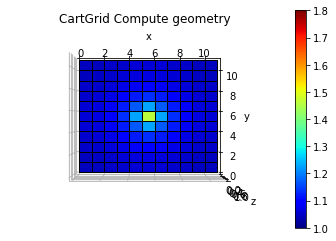

Solving time step:  2


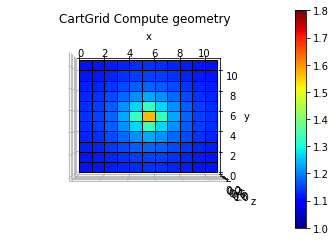

Solving time step:  3


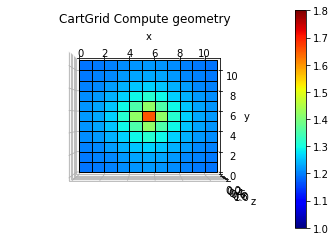

Solving time step:  4


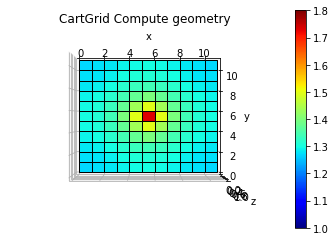

Solving time step:  5


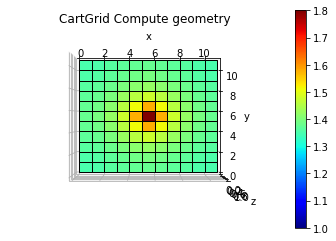

In [8]:
# Set initial condition
p0 = np.ones(gb.num_cells)
p = p0

# define iteration parameters
newton_tol = 1e-6
t = .0
T = 1
k = 0
times = [t]

# Time loop
while t < T:
    # Increment time
    t += dt
    k += 1
    times.append(t)
    p0 = p
    print('Solving time step: ', k)
    # solve newton iteration
    err = np.inf
    while err > newton_tol:
        pI = np.atleast_2d(p).repeat(p.size, axis=0)
        p0I = np.atleast_2d(p0).repeat(p0.size, axis=0)        
        p = p - np.linalg.solve(J(p, p0).T, f(p, p0))
        err = np.sqrt(np.sum(f(p, p0)**2))
    plot_grid(gb, p,color_map = [1., 1.8])